# Modelo Preditivo - Frequência de compra

#### Modelo desenvolvido para projeto final do curso de engenheiro de machine learning. 
Utilizando-se da base de dados 'Instacart Market Basket Analysis'.


## Objetivo

O objetivo desse modelo é tentar prever utilizando-se de regressão o tempo de o consumidor irá demorar para efetuar a compra novamente do produto.


## Pré-Processamento

Nesse inicio do projeto vamos inicializar todas as bibliotecas a serem utilizadas, assim como efetuar todo o tratamento de dados a serem necessários.

In [1]:
#Importando as bibliotecas
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.neighbors import NearestNeighbors

In [2]:
#Carregar base de pedidos
orders = pd.read_csv('Data/orders.csv')

#Devido a base possuir mais de 3 milhoes de registros, vamos estabelecer uma variavel para limita-la
limitItems = 1000

orders = orders[:limitItems]

print "Quantidade: "
print len(orders)

Quantidade: 
1000


In [3]:
#Obter informações do dataframe importado
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
order_id                  1000 non-null int64
user_id                   1000 non-null int64
eval_set                  1000 non-null object
order_number              1000 non-null int64
order_dow                 1000 non-null int64
order_hour_of_day         1000 non-null int64
days_since_prior_order    936 non-null float64
dtypes: float64(1), int64(5), object(1)
memory usage: 54.8+ KB


In [4]:
#Verificar os primeiros registros
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [5]:
#Verificar comportamento para 1 usuario
orders[orders.user_id == 1]

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0
5,3367565,1,prior,6,2,7,19.0
6,550135,1,prior,7,1,9,20.0
7,3108588,1,prior,8,1,14,14.0
8,2295261,1,prior,9,1,16,0.0
9,2550362,1,prior,10,4,8,30.0


Com essa análise inicial já podemos perceber que a primeira compra efetuada pelo consumidor apresenta valor NaN de 'days_since_prior_order' e que a coluna 'order_number' é sequencial

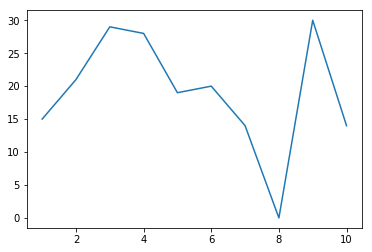

In [6]:
plt.plot(orders[orders.user_id == 1].days_since_prior_order)
plt.show()

Nota-se uma grande variância no perfil de compra desse usuário. Porém vamos importar a base de pedido x item e verificar o comportamento para cada item.

In [7]:
orderproductsprior = pd.read_csv('Data/order_products__prior.csv')

In [8]:
#Informacoes sobre a base de pedido x produto
orderproductsprior.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32434489 entries, 0 to 32434488
Data columns (total 4 columns):
order_id             int64
product_id           int64
add_to_cart_order    int64
reordered            int64
dtypes: int64(4)
memory usage: 989.8 MB


In [9]:
#primeiros registros
orderproductsprior.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


Vale ressaltar o campo 'reordered', que indica se é ou não uma recompra. Em outras palavras, para 0 é a primeira vez que o consumidor compra este produto na loja.

In [10]:
#Importar base de treino para aprimorar o algoritmo
orderproductstrain = pd.read_csv('Data/order_products__train.csv')

#Juntar ambas as bases
orderproducts = orderproductstrain.append(orderproductsprior)

#Vamos efetuar uma limpeza e utilizar apenas pedido x item que esteja na base de produtos
orderproducts = orderproducts[orderproducts.order_id.isin(orders.order_id)]

#juncao items
useritemsdf = pd.merge(orders, orderproducts, on='order_id', how='outer')

#liberar memoria do que não esta sendo usado
del orders
del orderproducts
del orderproductsprior
del orderproductstrain

Já temos em nosso dataframe a relação de pedido com items, porém o deparamento é uma informação relevante também. Pois a frequencia de compra pode estar associado ao departamento.

In [11]:
#importando produtos
products = pd.read_csv('Data/products.csv')

In [12]:
#Merge entre os pedido x item com produtos
df = pd.merge(useritemsdf, products)

del useritemsdf
del products

In [13]:
df.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id
0,2539329,1,prior,1,2,8,NaN,196,1.0,0.0,Soda,77,7
1,2398795,1,prior,2,3,7,15.0,196,1.0,1.0,Soda,77,7
2,473747,1,prior,3,3,12,21.0,196,1.0,1.0,Soda,77,7
3,2254736,1,prior,4,4,7,29.0,196,1.0,1.0,Soda,77,7
4,431534,1,prior,5,4,15,28.0,196,1.0,1.0,Soda,77,7


Feito isso, trouxemos todos os atributos relevantes ou não para a criação do nosso modelo. Agora nossa tarefa é analisar e remover atributos que não contribuam para nossa solução.

In [14]:
#Remover primeiro pedidos dos consumidores, pois não há tempo de ultima compra (NaN)
df = df[df.reordered == 1]
df = df[df.days_since_prior_order > 0]
df.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id
1,2398795,1,prior,2,3,7,15.0,196,1.0,1.0,Soda,77,7
2,473747,1,prior,3,3,12,21.0,196,1.0,1.0,Soda,77,7
3,2254736,1,prior,4,4,7,29.0,196,1.0,1.0,Soda,77,7
4,431534,1,prior,5,4,15,28.0,196,1.0,1.0,Soda,77,7
5,3367565,1,prior,6,2,7,19.0,196,1.0,1.0,Soda,77,7


In [15]:
#Selecionar apenas os atributos de interesse
dfFiltered = df.iloc[:, [1,3,4,5,6,7,12]]
dfFiltered.head()

,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,department_id
1,1,2,3,7,15.0,196,7
2,1,3,3,12,21.0,196,7
3,1,4,4,7,29.0,196,7
4,1,5,4,15,28.0,196,7
5,1,6,2,7,19.0,196,7


In [16]:
#Com os dados devidamente selecionados
df = dfFiltered

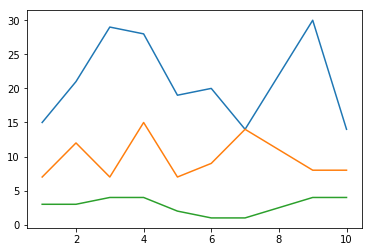

In [17]:
#relacao consumidor x item
plt.plot(df[(df.user_id == 1) & (df.product_id == 196)].days_since_prior_order)
plt.plot(df[(df.user_id == 1) & (df.product_id == 196)].order_hour_of_day)
plt.plot(df[(df.user_id == 1) & (df.product_id == 196)].order_dow)
plt.show()

No gráfico acima, podemos perceber que para o consumidor 1, o minimo de tempo que ele espera para comprar o produto é de 15 dias e o máximo que ele esperou foi de 30 dias.

In [18]:
#Atribuir média de tempo ultima compra ao dataframe
df["mean_days_since_order_user"] = 0.0

for index,row in df.iterrows():
    #print row['user_id']
    dfsel = df[(df.user_id == row['user_id']) & (df.product_id == row['product_id'])]
    median = dfsel.days_since_prior_order
    
    df.loc[index, "mean_days_since_order_user"] = np.mean(median) 

In [19]:
df.head()

,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,department_id,mean_days_since_order_user
1,1,2,3,7,15.0,196,7,21.111111
2,1,3,3,12,21.0,196,7,21.111111
3,1,4,4,7,29.0,196,7,21.111111
4,1,5,4,15,28.0,196,7,21.111111
5,1,6,2,7,19.0,196,7,21.111111


## Desenvolvimento

Agora que já temos nosso dataframe pronto para trabalhar, vamos separar as features, labels.
Vamos também separar o conjunto em teste e treino, e aplicar o algoritmo desejado.

In [26]:
#Separando features e labels
features = df.iloc[:, [0,1,2,3,5,6,7]]
features.head()

labels = df.iloc[:, [4]]
labels.head()

,days_since_prior_order
1,15.0
2,21.0
3,29.0
4,28.0
5,19.0


In [68]:
#Agora vamos aplicar um modelo de regressão e utilizar gridSearch para tentar obter a melhor parametrização
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.4, random_state=2)

# use a full grid over all parameters
param_grid = {"max_depth": [3, None],
              "n_estimators": [100, 200],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10]}

#param_grid = {"n_estimators": [100, 200],
#              "loss": ["linear", "square", "exponential"]
#             }

clf = GridSearchCV(GradientBoostingRegressor(), param_grid=param_grid)
clf.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [100, 200], 'min_samples_split': [2, 3, 10], 'max_depth': [3, None], 'min_samples_leaf': [1, 3, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [69]:
clf.best_estimator_

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=None,
             max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=10, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=200,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False)

In [70]:
clf.best_params_

{'max_depth': None,
 'min_samples_leaf': 10,
 'min_samples_split': 2,
 'n_estimators': 200}

In [71]:
clf.best_score_

0.73915377826540829

In [84]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
y_pred = clf.predict(X_test)

print r2_score(y_test, y_pred)

0.785069165978


O modelo apresentou um indice R2 equivalente a 0.785069165978, indicando que irá apresentar boas previsões.

## Resultados

Na seção abaixo vamos apresentar os resultados obtidos pelo modelo e observações gerais.

### Visualização do modelo
O gráfico abaixo  tem objetivo de visualizar uma previsão do modelo com o real.

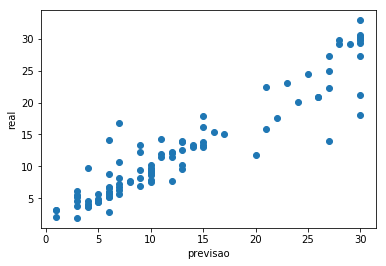

In [81]:
res = clf.predict(X_test.iloc[:100, :])

plt.scatter(y_test.iloc[:100,:],res)
plt.xlabel('previsao')
plt.ylabel('real')
plt.show()

Na visualização acima podemos perceber a tendencia do gráfico em estabelecer uma reta linear.
Podemos fazer uma observação tentando pegar a reta equivalente com minimos quadrados.

## Considerações

Fiquei satisfeito com o modelo de previsão e seus resultados preditivos.
Durante o processo de desenvolvimento do projeto tive uma grande curva de aprendizado em relação ao python, para gerar o pre-processamento de dados e suas visualizações.
Visualizando as outras soluções do kaggle para essa base de dados, notei que há muito ainda para aprender sobre essa área e estou com ótimas perspectivas.

### Benchmark

Não consegui encontrar uma aplicação com comparações diretas a esse modelo. No link descrito (https://www.kaggle.com/philippsp/exploratory-analysis-instacart) encontra-se uma solução para a mesma base de dados, porém ele utiliza como label a classificação da variavel 'recompra'.

;)